# Import Libraries

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from collections import defaultdict

import stumpy

# Data Prep

In [2]:
def load_npy(filename):
    return np.load(filename)
path = "Output_Saved/X_y_ids.npz"
# reload 
X_y_ids = load_npy(f"{path}") 
X, y, ids = X_y_ids['arr_0'], X_y_ids['arr_1'], X_y_ids['arr_2']


In [3]:
#per trasformare in dataframe

df = pd.DataFrame(np.squeeze(X))
df["genre"] = y
df.shape


(10000, 1281)

In [4]:
a = ['happy','piano']
df_filtered = df[df['genre'].isin(a)] 
df_filtered.shape


(1000, 1281)

In [5]:
# Assegna la variabile target
y = df_filtered.iloc[:, -1].values

# Assegna il resto dei valori a X escludendo l'ultima colonna
X = df_filtered.iloc[:, :-1].values
X.shape, y.shape


((1000, 1280), (1000,))

In [6]:
from sklearn.preprocessing import LabelEncoder

# Inizializza e addestra il LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [7]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
import numpy as np
from tslearn.metrics import dtw


# Definiamo il numero di classi di genere musicale
num_classi = 2

# Inizializziamo un dizionario per memorizzare i centroidi per ciascuna classe di genere musicale
centroidi_per_classe = {}

# Convertiamo le serie temporali in un formato compatibile con tslearn
#X = to_time_series_dataset(X)

# Dividiamo il dataset in subset per ogni classe di genere musicale
for classe in range(num_classi):
    subset_X = X[y_encoded == classe]  # Seleziona solo le serie temporali appartenenti alla classe corrente
    kmeans = TimeSeriesKMeans(n_clusters=1, metric= "euclidean", verbose=0, random_state=42).fit(subset_X)  # Esegui TimeSeriesKMeans con k=1
    centroidi_per_classe[classe] = kmeans.cluster_centers_[0]  # Salva il centroide per la classe corrente


/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/DM2_UNIPI_Prj/env/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [8]:
centroidi_per_classe


{0: array([[2997.19839046],
        [2978.42941568],
        [2970.81105579],
        ...,
        [2854.73276492],
        [2839.3016486 ],
        [2801.58333856]]),
 1: array([[925.99570759],
        [941.19267866],
        [965.6552027 ],
        ...,
        [955.3910824 ],
        [951.40904176],
        [932.4140462 ]])}

In [9]:
c0 = centroidi_per_classe[0]
c1 = centroidi_per_classe[1]

<function matplotlib.pyplot.show(close=None, block=None)>

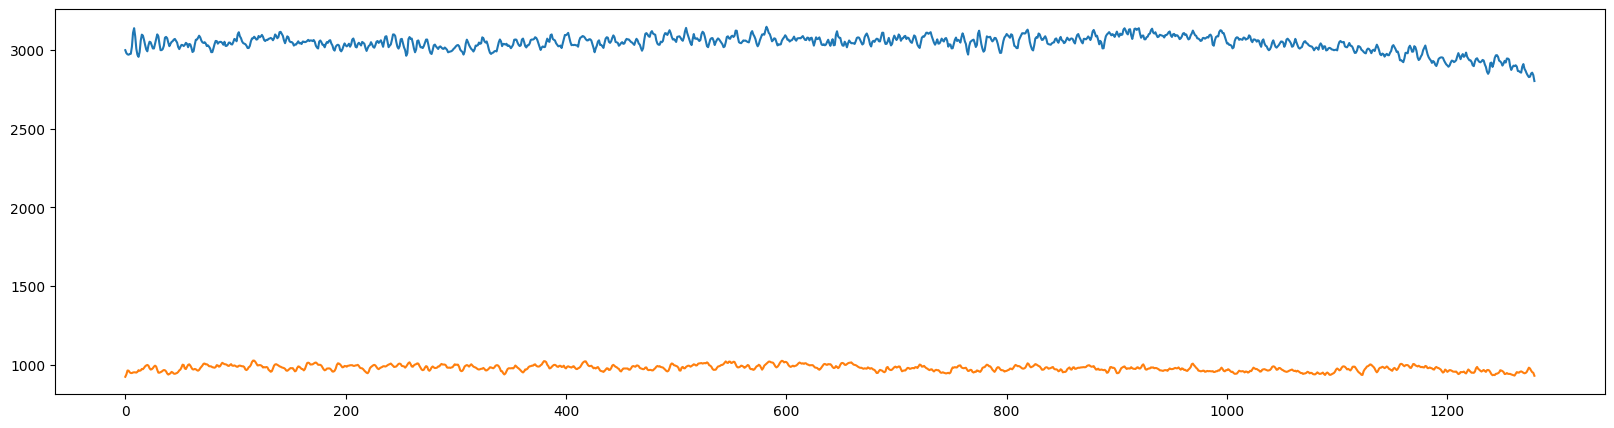

In [10]:
plt.figure(figsize=(20,5))
plt.plot(c0)
plt.plot(c1)
plt.show


In [11]:
centr = np.array([c0,c1])
centr = centr.squeeze()
centr.shape

(2, 1280)

In [12]:
from scipy.spatial.distance import cdist
from fastdtw import fastdtw
from pyts.approximation import DiscreteFourierTransform
from tslearn.clustering import silhouette_score 


# Get the centroids
def getNearestTS(data, centroids):
    centroids = np.squeeze(centroids)

    # Function to calculate DTW distance between two time series
    def dtw_distance(ts1, ts2):
        distance, _ = fastdtw(ts1, ts2)
        return distance

    # Calculate the distance between each centroid and all time series data points
    distances = cdist(centroids, data, metric=dtw_distance) #euclidean?

    # Find the nearest time series for each centroid
    nearest_indices = np.argmin(distances, axis=1)

    # Retrieve the nearest time series for each centroid
    #nearest_time_series = [x_train_dft[i] for i in nearest_indices]

    # Print the results
    for i, centroid in enumerate(centroids):
        print (f"Centroid {i}: Nearest Time Series Index = {nearest_indices[i]}")


In [ ]:
#getNearestTS(X,centr)

In [13]:
def moving_average_smoothing(series, window_size):
    """
    Perform moving average smoothing on a single time series.
    
    series: Input time series as a 1-dimensional numpy array.
    window_size: Size of the moving window as an integer.
    
    Returns the smoothed time series.
    """
    window = np.ones(window_size) / window_size
    smoothed_series = np.convolve(series, window, mode='same')
    return smoothed_series


X_app = X.copy()

w = 10 
for i,time_series in enumerate(X_app):
    X_app[i]= moving_average_smoothing(X_app[i], w)


<function matplotlib.pyplot.show(close=None, block=None)>

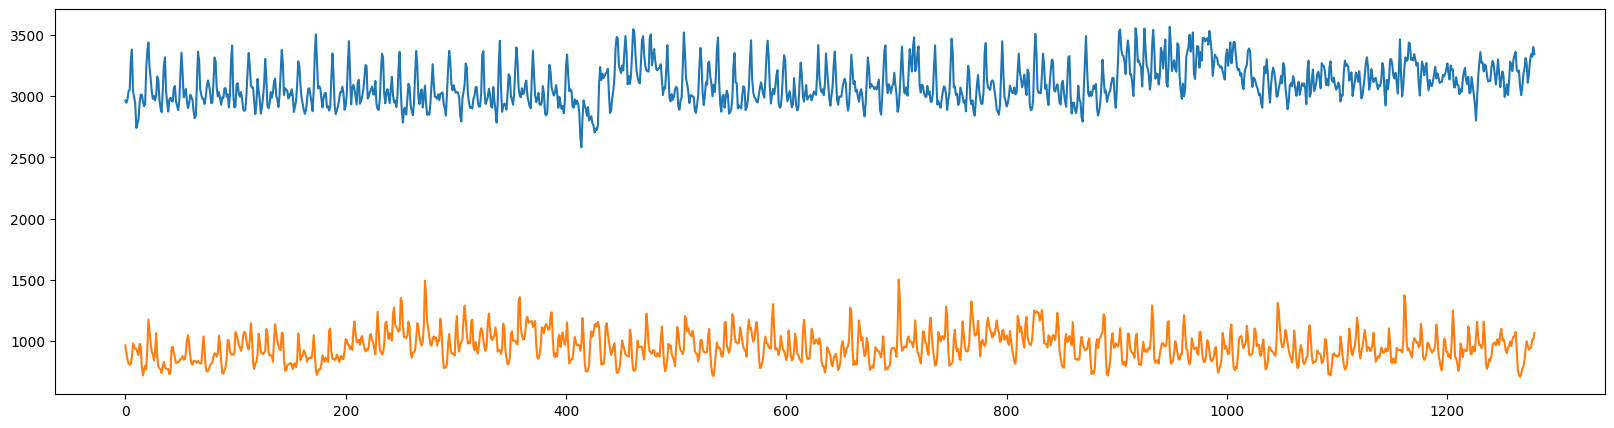

In [14]:
plt.figure(figsize=(20,5))
plt.plot(X[806])
plt.plot(X[788])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

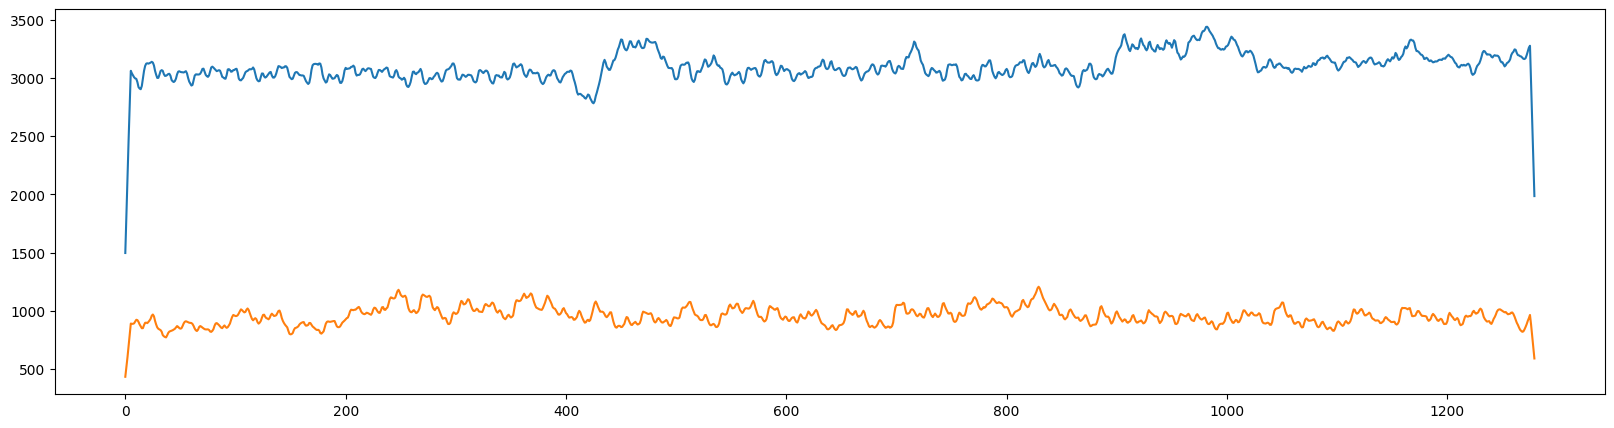

In [15]:
#plotto

ts0 = X_app[806]
ts1 = X_app[788]

# ts0 = X_app[474]
# ts1 = X_app[345]

plt.figure(figsize=(20,5))
plt.plot(ts0)
plt.plot(ts1)
plt.show


In [16]:
from pyts.approximation import PiecewiseAggregateApproximation

window_size = 4

paa = PiecewiseAggregateApproximation(window_size=window_size)
X_paa = paa.transform(X_app)
X_paa.shape


(1000, 320)

<function matplotlib.pyplot.show(close=None, block=None)>

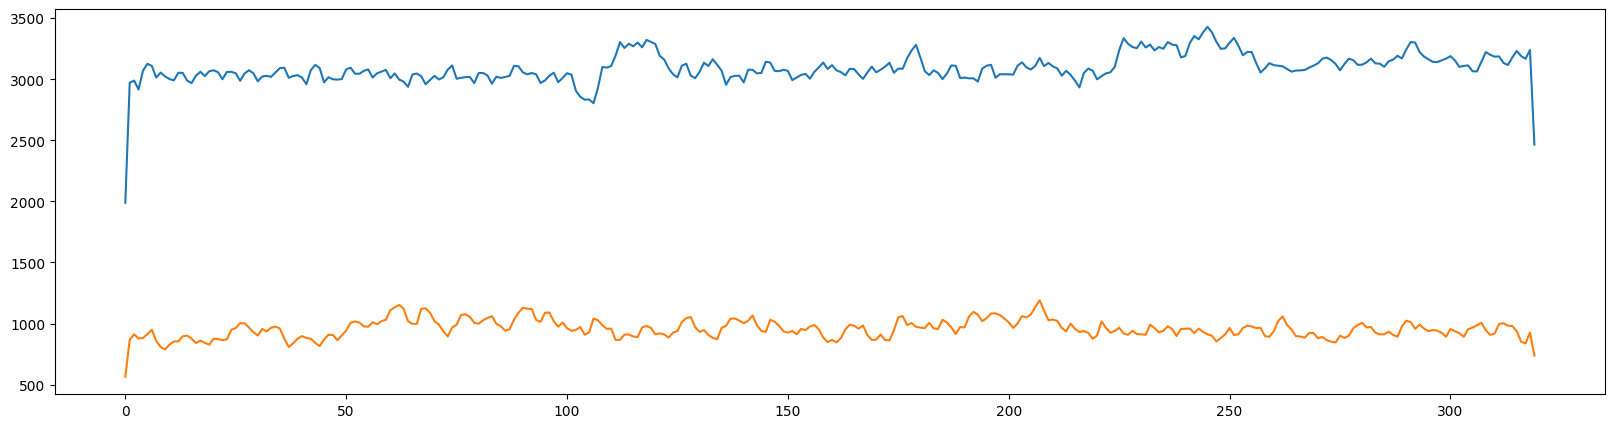

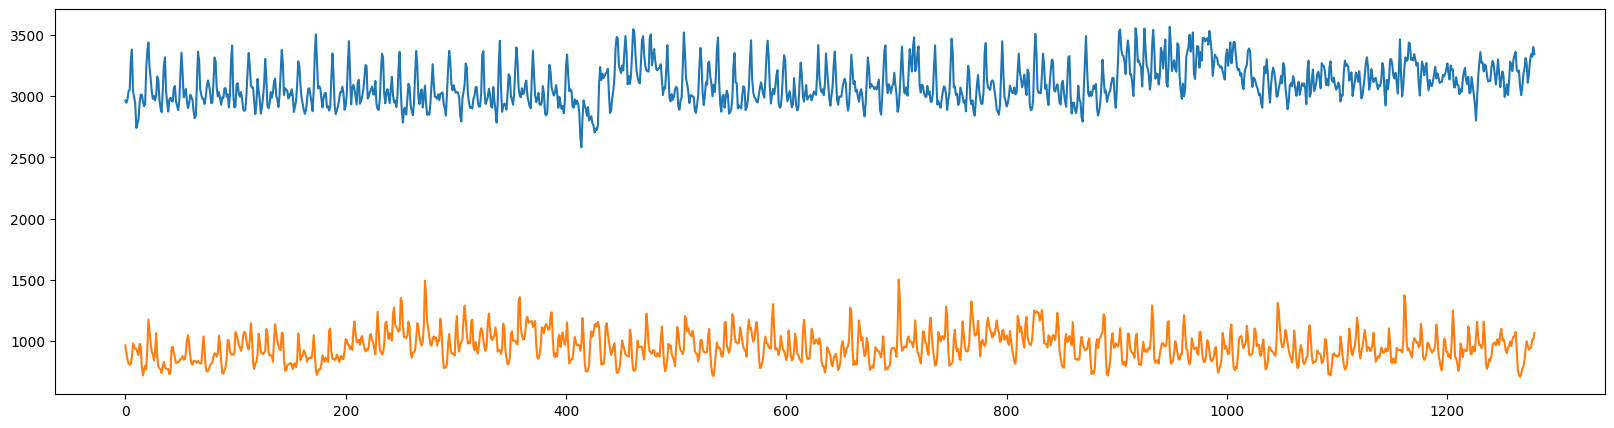

In [17]:
ts0_paa = X_paa[806]
ts1_paa = X_paa[788]

ts0 = X[806]
ts1 = X[788]

# ts0 = X_app[474]
# ts1 = X_app[345]

plt.figure(figsize=(20,5))
plt.plot(ts0_paa)
plt.plot(ts1_paa)
plt.show

plt.figure(figsize=(20,5))
plt.plot(ts0)
plt.plot(ts1)
plt.show


# Motifs

# PAA

## Ts0

In [99]:
ts0_paa = pd.Series(ts0_paa)
ts0_paa

0      1989.289915
1      2972.591316
2      2989.513914
3      2916.332367
4      3070.560921
          ...     
315    3231.869250
316    3190.401658
317    3167.928623
318    3240.008188
319    2465.011485
Length: 320, dtype: float64

In [100]:
w = 15
mp = stumpy.stump(ts0_paa.values, w)
mod, mo = stumpy.motifs(
        ts0_paa.values,
        mp.P_,
        max_matches = 2,
        max_motifs=10,     # Up to 10 motifs
        min_neighbors=1, 
        cutoff = 1.7
)

mod, mo

(array([[0.        , 1.34781942],
        [0.        , 1.38106784],
        [0.        , 1.38479158],
        [0.        , 1.40668935],
        [0.        , 1.51224671],
        [0.        , 1.56591423],
        [0.        , 1.58547211],
        [0.        , 1.5918766 ],
        [0.        , 1.61037148],
        [0.        , 1.61256766]]),
 array([[ 86, 143],
        [ 93, 112],
        [177, 290],
        [ 40, 192],
        [ 26,  64],
        [213, 278],
        [106, 220],
        [ 32, 184],
        [247, 114],
        [ 77,  62]]))

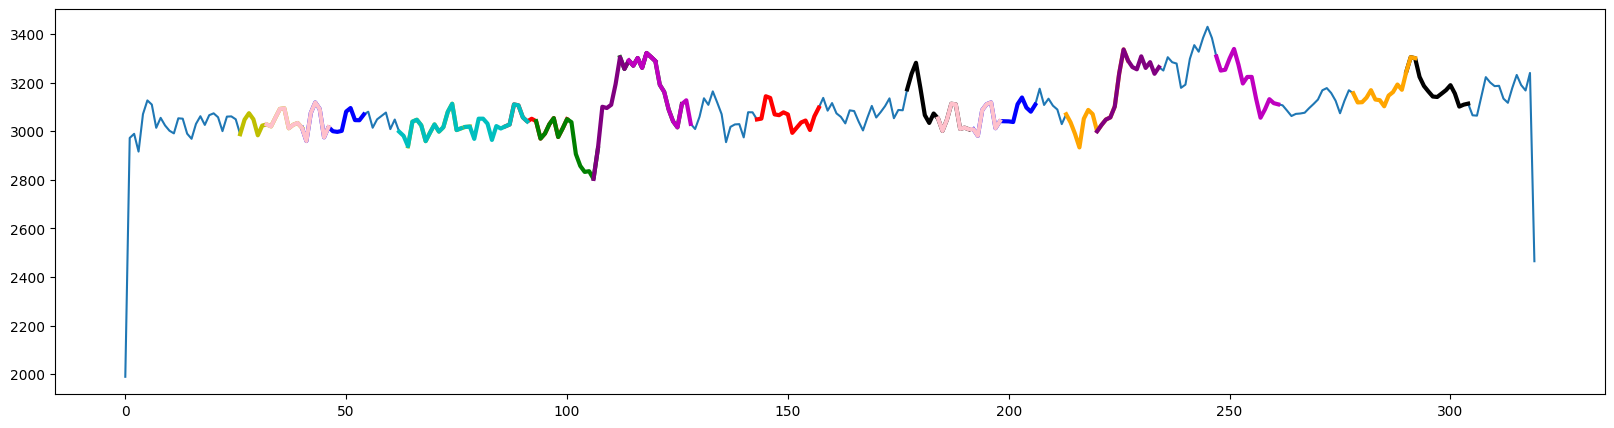

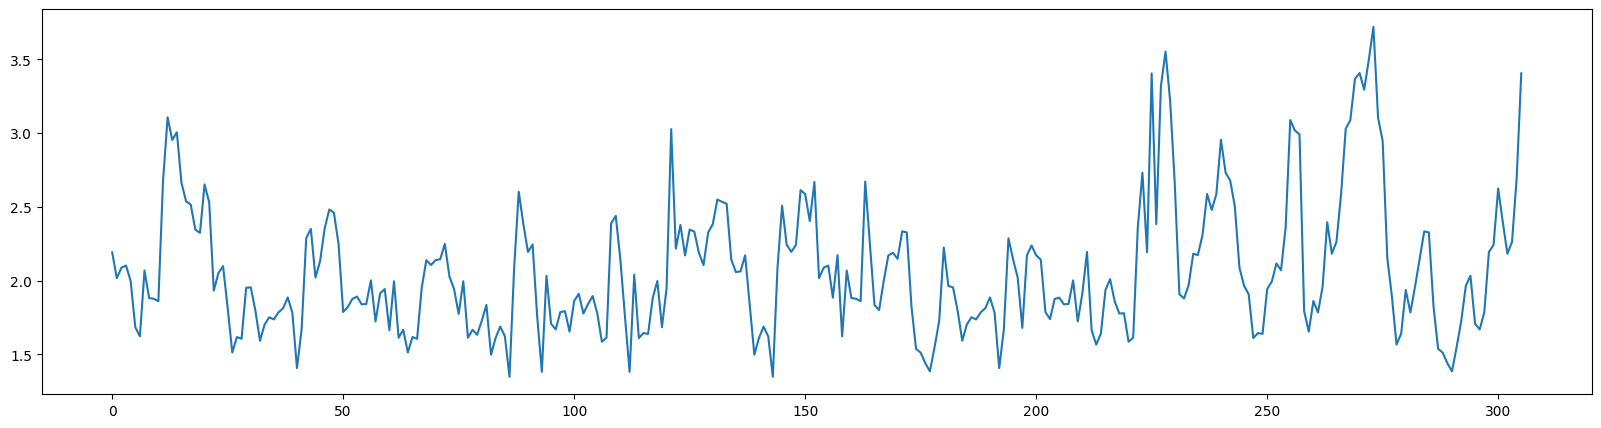

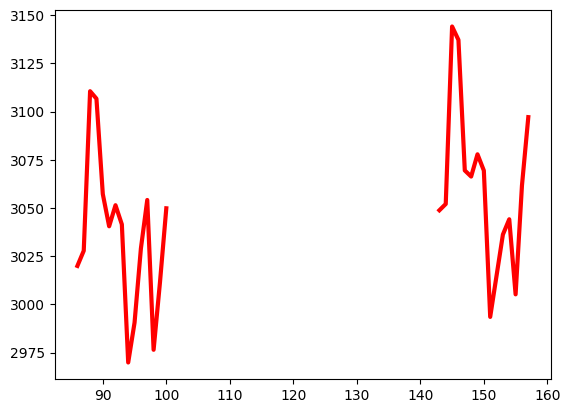

<Figure size 2000x500 with 0 Axes>

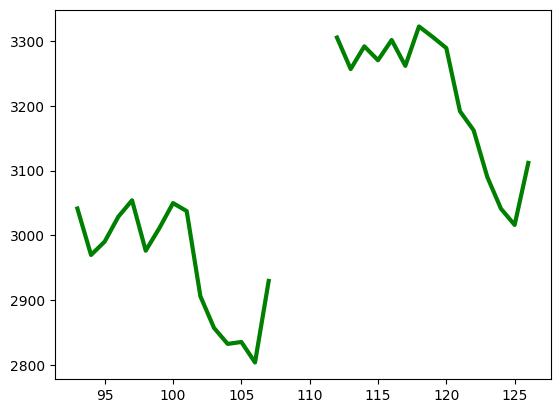

<Figure size 2000x500 with 0 Axes>

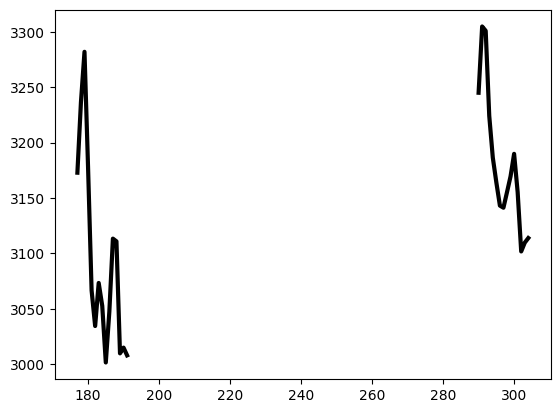

<Figure size 2000x500 with 0 Axes>

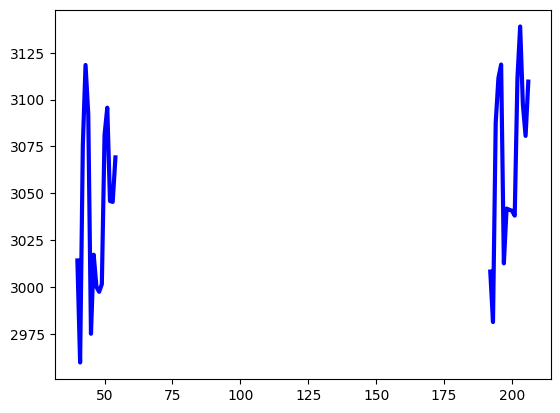

<Figure size 2000x500 with 0 Axes>

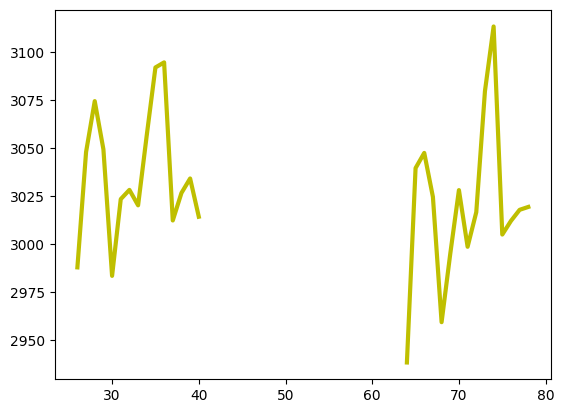

<Figure size 2000x500 with 0 Axes>

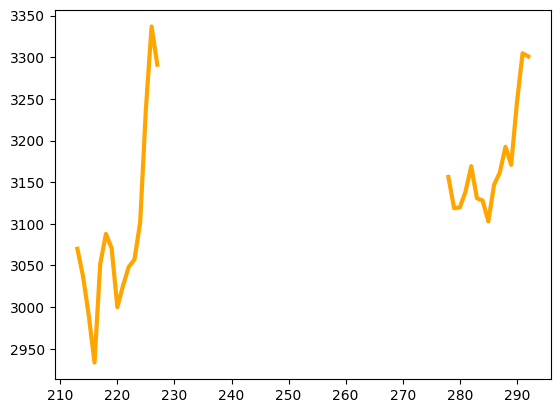

<Figure size 2000x500 with 0 Axes>

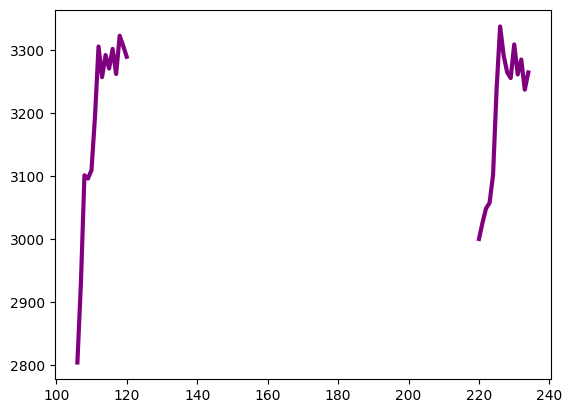

<Figure size 2000x500 with 0 Axes>

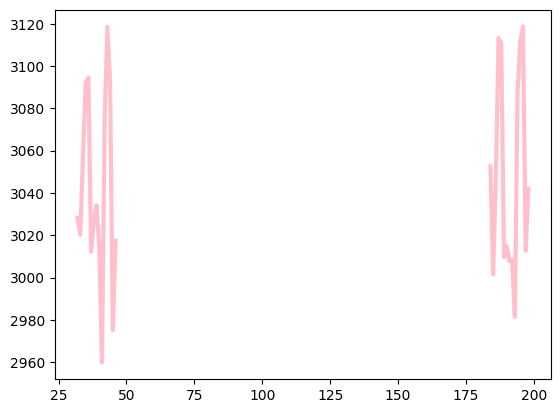

<Figure size 2000x500 with 0 Axes>

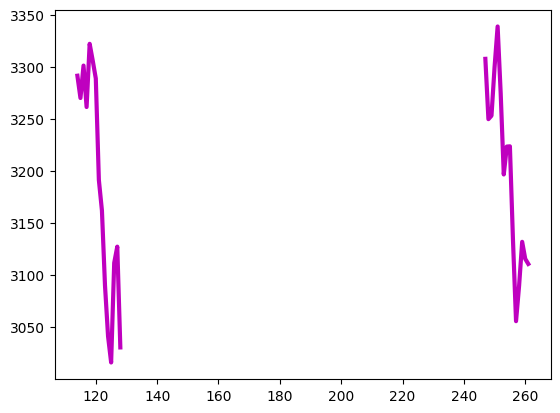

<Figure size 2000x500 with 0 Axes>

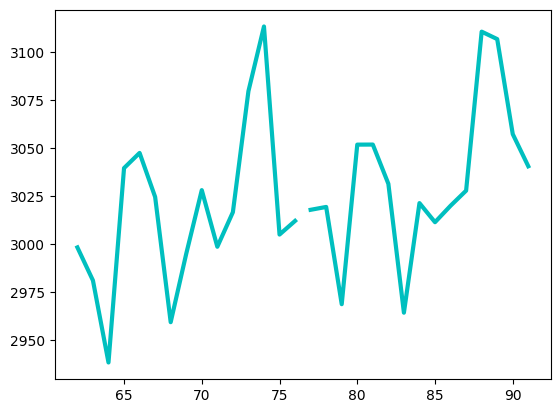

<Figure size 2000x500 with 0 Axes>

In [101]:
plt.figure(figsize=(20,5))
plt.plot(ts0_paa.values)
colors = ['r', 'g', 'k', 'b', 'y', 'orange', 'purple', 'pink', 'm', 'c'][:len(mo)]   #sono 10
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts0_paa.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

plt.figure(figsize=(20,5))
plt.plot(mp.P_)  # First column: matrix profile
plt.show()

for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts0_paa.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.figure(figsize=(20,5))
    plt.show()

## Ts1

In [102]:
ts1_paa = pd.Series(ts1_paa)

In [103]:
w = 15
mp = stumpy.stump(ts1_paa.values, w)
mod, mo = stumpy.motifs(
        ts1_paa.values,
        mp.P_,
        max_matches = 2,
        max_motifs=10,     # Up to 10 motifs
        min_neighbors=1, 
        cutoff = 1.7
)

mod, mo

(array([[0.        , 0.91957178],
        [0.        , 1.2446616 ],
        [0.        , 1.2923681 ],
        [0.        , 1.38312098],
        [0.        , 1.39256581],
        [0.        , 1.49339097],
        [0.        , 1.54095734],
        [0.        , 1.56830166],
        [0.        , 1.6034997 ],
        [0.        , 1.61297202]]),
 array([[161, 276],
        [166, 281],
        [193, 265],
        [ 16, 270],
        [ 40,  14],
        [ 72, 187],
        [205, 260],
        [ 95, 210],
        [106,  95],
        [120, 199]]))

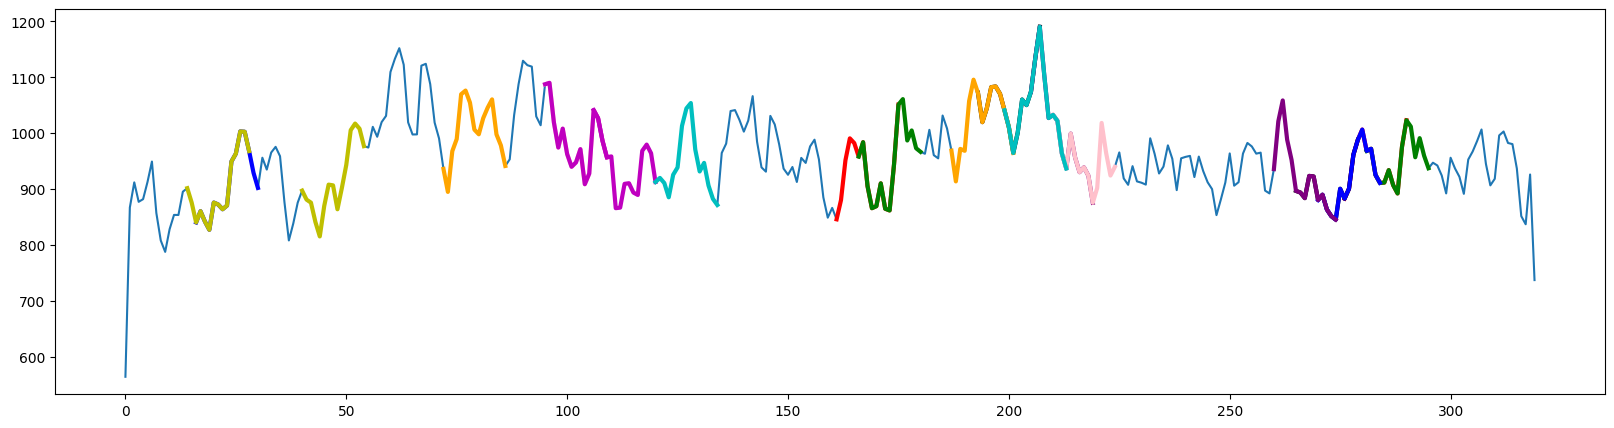

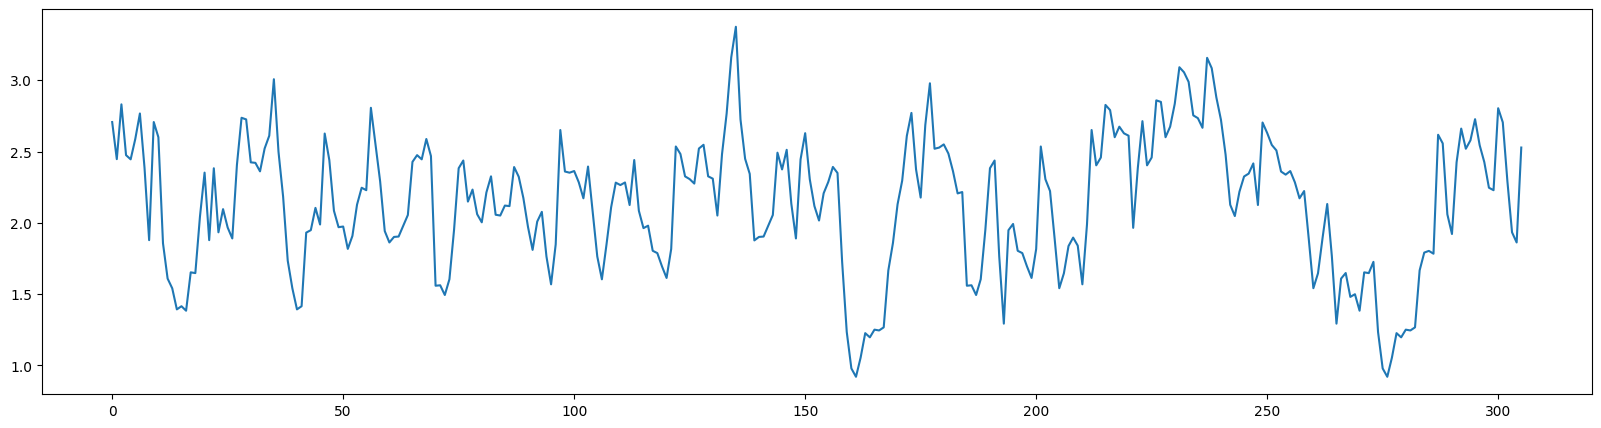

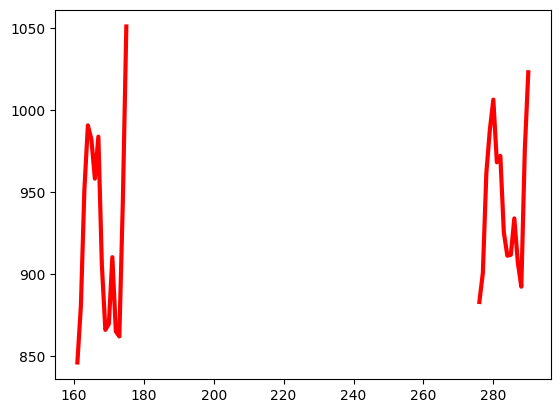

<Figure size 2000x500 with 0 Axes>

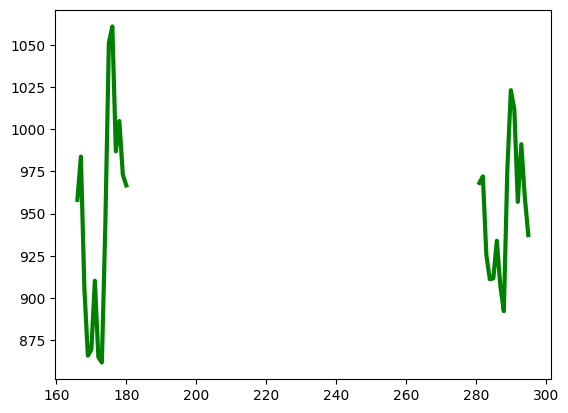

<Figure size 2000x500 with 0 Axes>

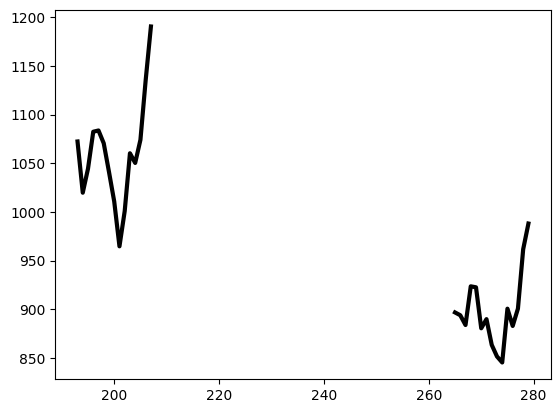

<Figure size 2000x500 with 0 Axes>

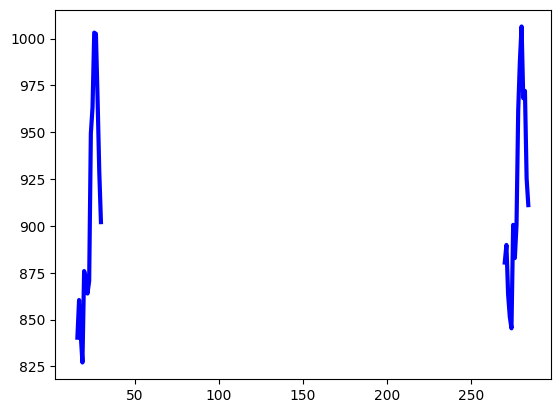

<Figure size 2000x500 with 0 Axes>

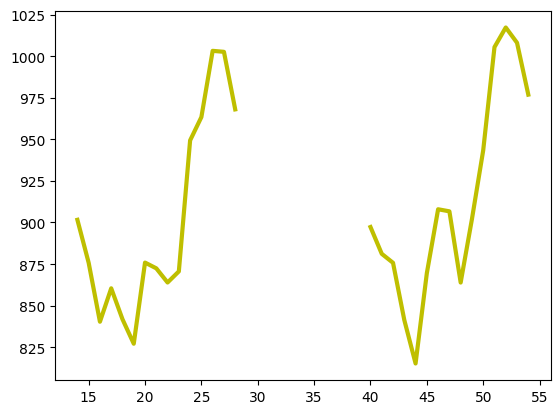

<Figure size 2000x500 with 0 Axes>

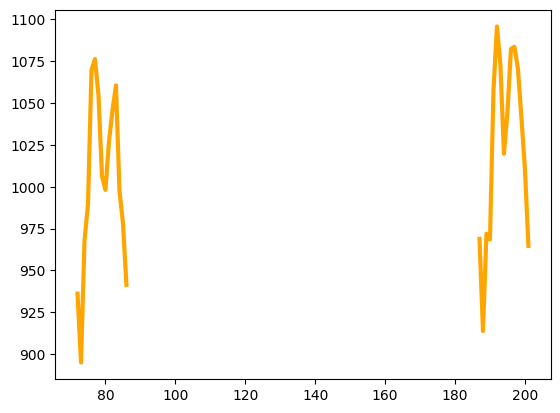

<Figure size 2000x500 with 0 Axes>

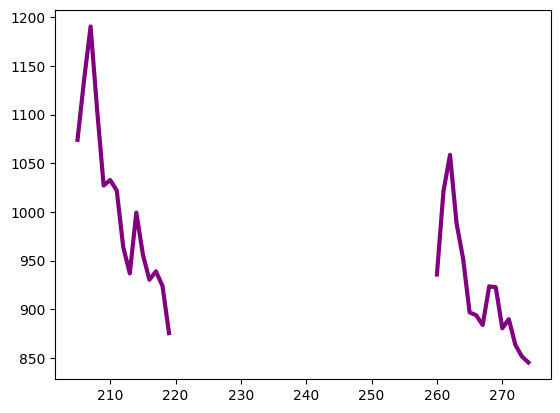

<Figure size 2000x500 with 0 Axes>

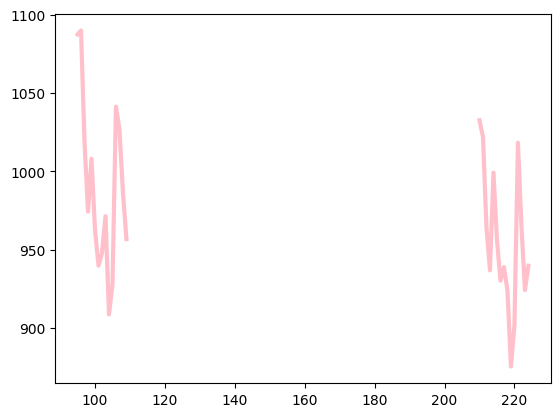

<Figure size 2000x500 with 0 Axes>

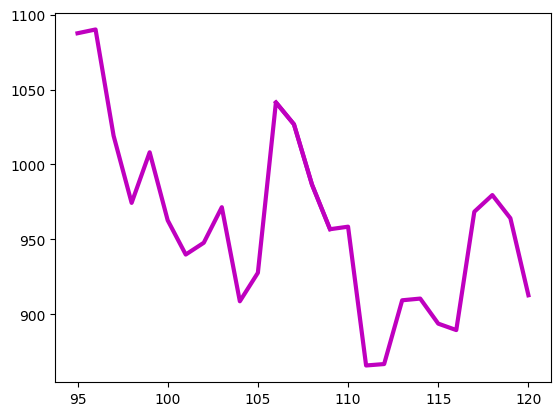

<Figure size 2000x500 with 0 Axes>

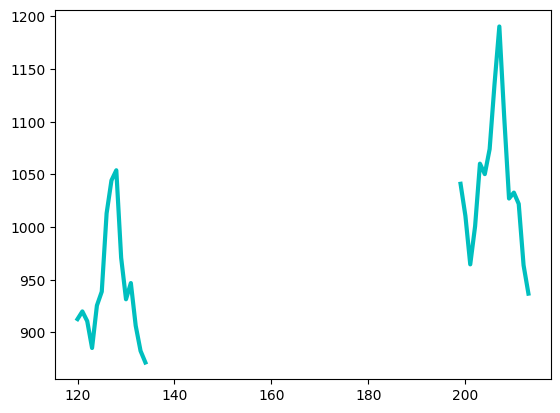

<Figure size 2000x500 with 0 Axes>

In [104]:
plt.figure(figsize=(20,5))
plt.plot(ts1_paa.values)
colors = ['r', 'g', 'k', 'b', 'y', 'orange', 'purple', 'pink', 'm', 'c'][:len(mo)]   #sono 10
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts1_paa.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

plt.figure(figsize=(20,5))
plt.plot(mp.P_)  # First column: matrix profile
plt.show()

for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = ts1_paa.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.figure(figsize=(20,5))
    plt.show()

# Discords

## Ts1

In [93]:
w = 15
mp = stumpy.stump(ts1_paa.values, w)


In [94]:
df_mp = pd.DataFrame(mp, columns=['Distances', 'Index', 'DNC', 'DNC'])
df_mp = df_mp.drop(columns=['DNC', 'DNC'])

In [95]:
df_mp.head()

,Distances,Index
0,2.706839,9
1,2.446562,152
2,2.830987,65
3,2.474674,66
4,2.445252,67


In [96]:
# Find the top 10% anomalies (discords)
threshold = df_mp['Distances'].quantile(0.99)
discords = df_mp[df_mp['Distances'] >= threshold].sort_values(by='Distances', ascending=False)


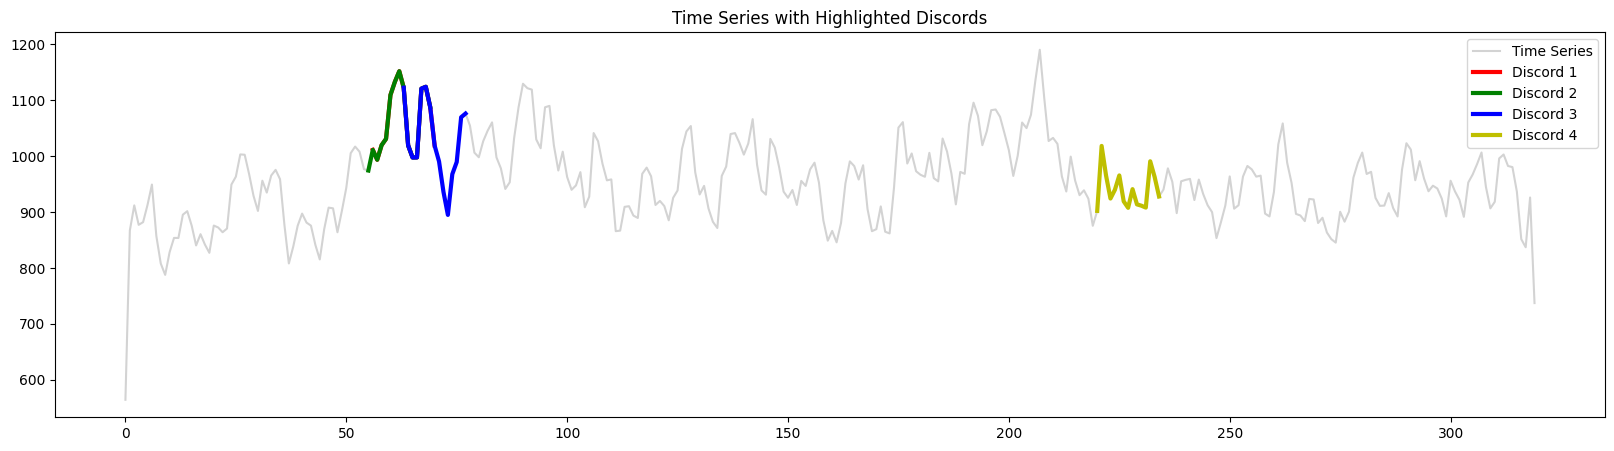

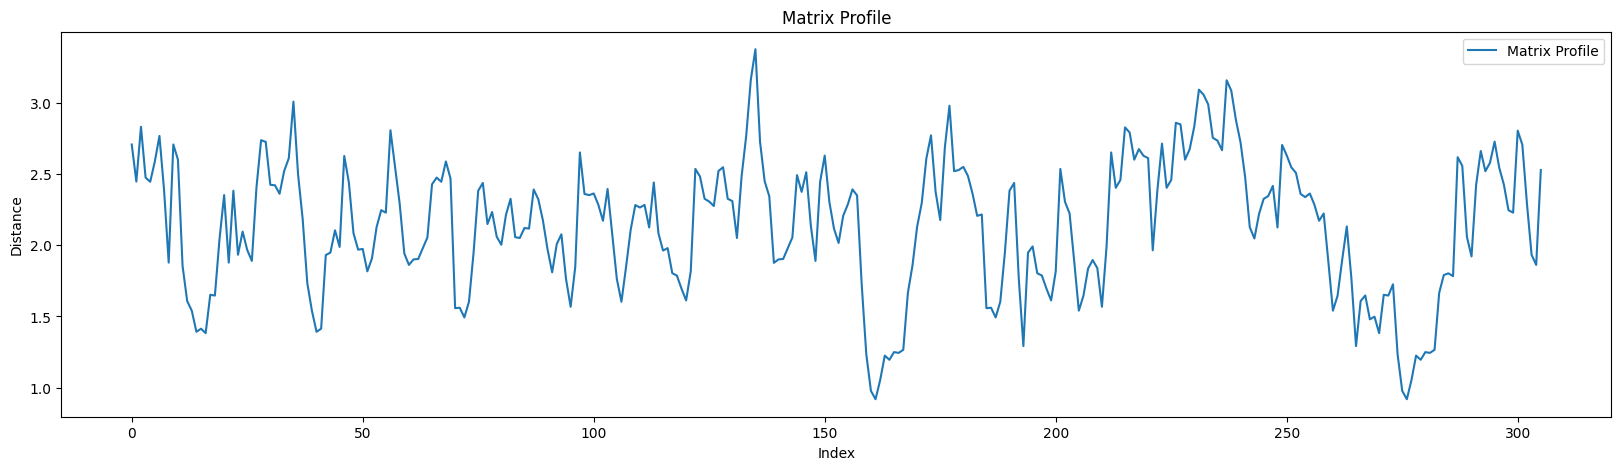

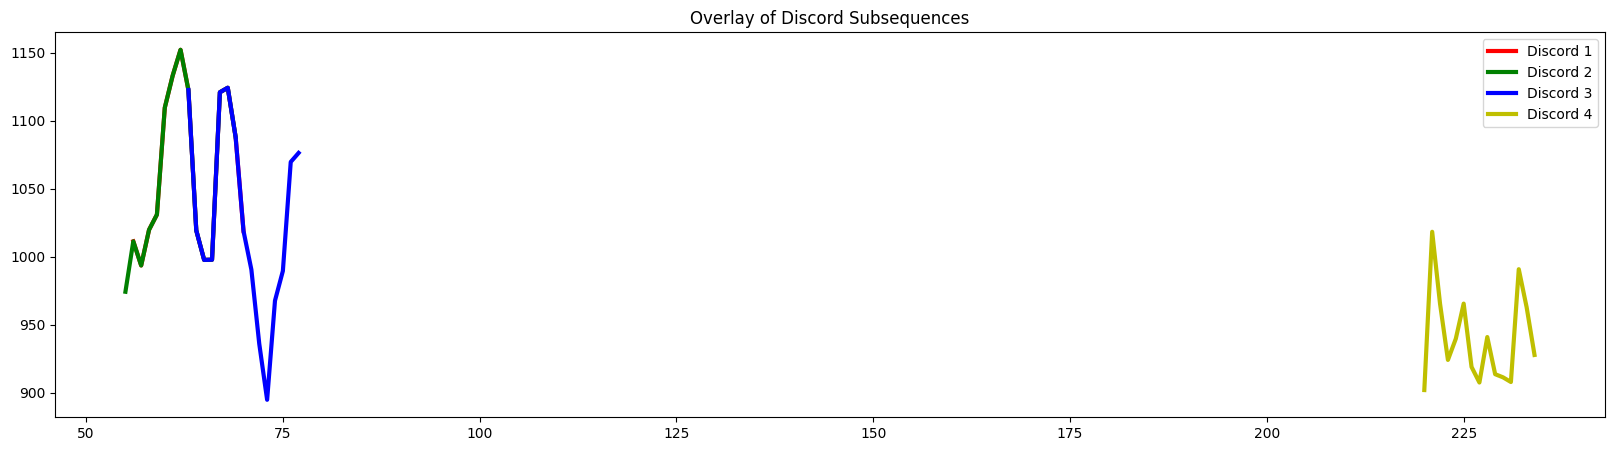

In [98]:
import matplotlib.pyplot as plt

# Parameters
w = 15  # Window size

# Visualize the time series and highlight the discords
plt.figure(figsize=(20, 5))
plt.plot(ts1_paa.values, label="Time Series", color="lightgray")
colors = ['r', 'g', 'b', 'y', 'orange', 'purple', 'pink', 'm', 'c'][:len(discords)]

# Highlight discords
for i, (idx, row) in enumerate(discords.iterrows()):
    start = int(row['Index'])
    discord_shape = ts1_paa.values[start:start+w]
    plt.plot(range(start, start+w), discord_shape, color=colors[i % len(colors)], lw=3, label=f"Discord {i+1}")

plt.title("Time Series with Highlighted Discords")
plt.legend()
plt.show()

# Plot the matrix profile
plt.figure(figsize=(20, 5))
plt.plot(df_mp['Distances'], label="Matrix Profile")
plt.title("Matrix Profile")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.legend()
plt.show()

# Overlay the discord subsequences
plt.figure(figsize=(20, 5))
for i, (idx, row) in enumerate(discords.iterrows()):
    start = int(row['Index'])
    discord_shape = ts1_paa.values[start:start+w]
    plt.plot(range(start, start+w), discord_shape, color=colors[i % len(colors)], lw=3, label=f"Discord {i+1}")

plt.title("Overlay of Discord Subsequences")
plt.legend()
plt.show()


## Ts0

In [55]:
w = 15
mp = stumpy.stump(ts0_paa.values, w)


In [59]:
df_mp = pd.DataFrame(mp, columns=['Distances', 'Index', 'DNC', 'DNC'])

In [61]:
df_mp = df_mp.drop(columns=['DNC', 'DNC'])

In [62]:
df_mp.head()

,Distances,Index
0,2.191652,224
1,2.016171,153
2,2.087247,154
3,2.101684,155
4,1.996756,118


In [79]:
df_mp.quantile(0.95)[0]

/var/folders/kz/z9pm_78940q0wmly2vd_r41h0000gn/T/ipykernel_67370/2240659604.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



3.024016949375699

In [86]:
# Find the top 10% anomalies (discords)
threshold = df_mp['Distances'].quantile(0.99)
discords = df_mp[df_mp['Distances'] >= threshold].sort_values(by='Distances', ascending=False)


In [87]:
discords

,Distances,Index
273,3.720406,237
228,3.552396,294
272,3.496221,121
270,3.406931,157


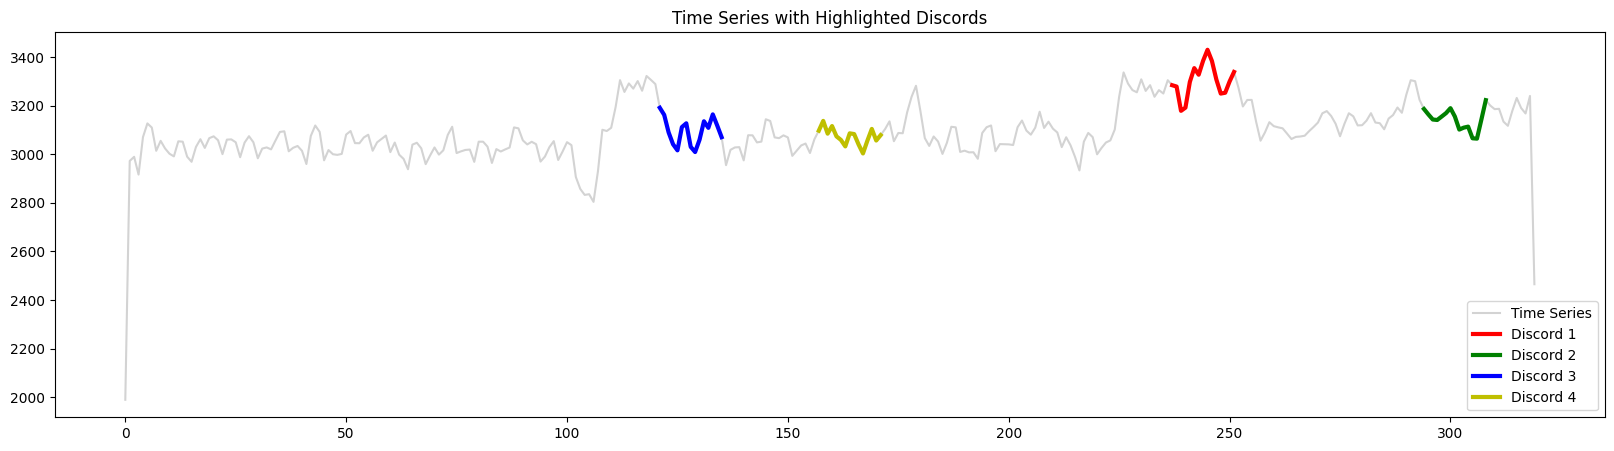

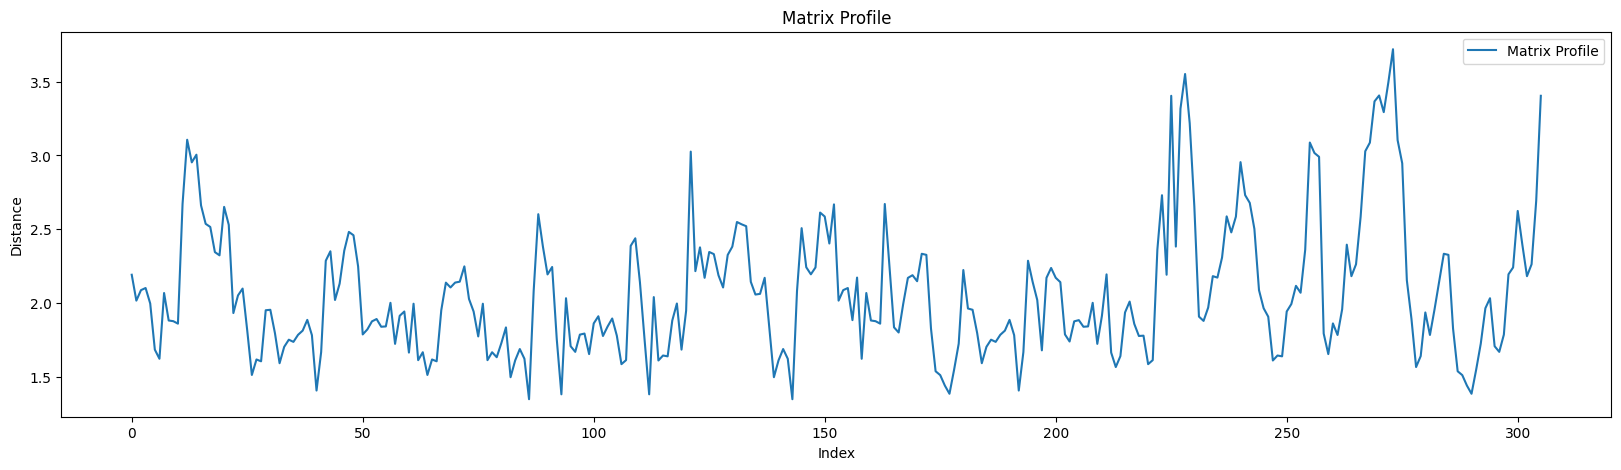

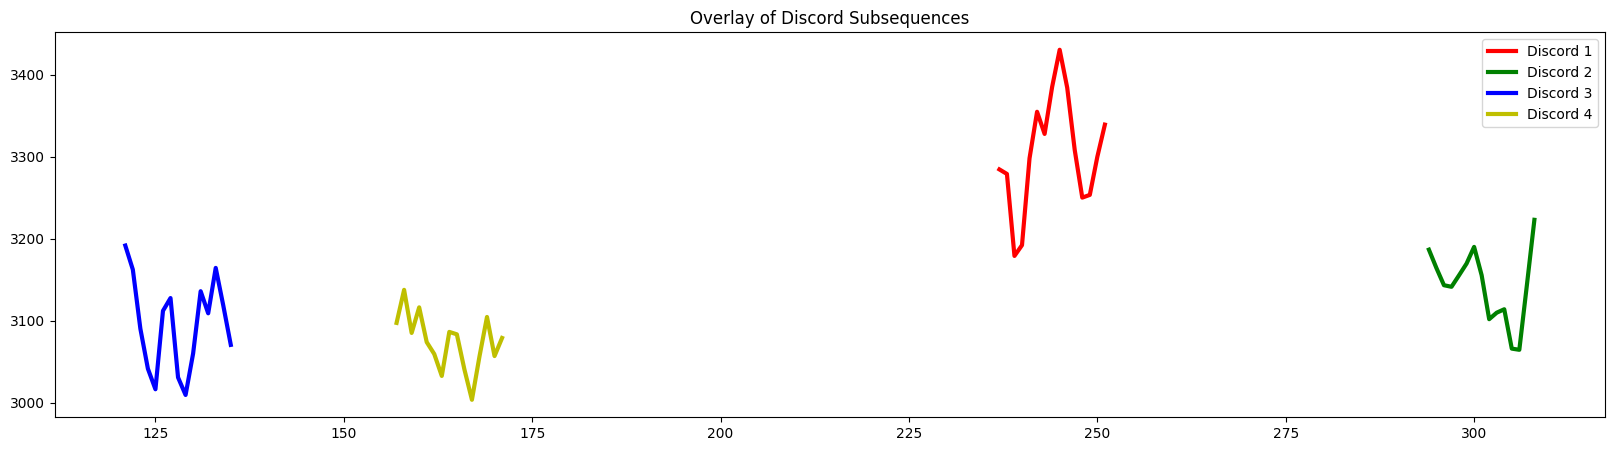

In [88]:
import matplotlib.pyplot as plt

# Parameters
w = 15  # Window size

# Visualize the time series and highlight the discords
plt.figure(figsize=(20, 5))
plt.plot(ts0_paa.values, label="Time Series", color="lightgray")
colors = ['r', 'g', 'b', 'y', 'orange', 'purple', 'pink', 'm', 'c'][:len(discords)]

# Highlight discords
for i, (idx, row) in enumerate(discords.iterrows()):
    start = int(row['Index'])
    discord_shape = ts0_paa.values[start:start+w]
    plt.plot(range(start, start+w), discord_shape, color=colors[i % len(colors)], lw=3, label=f"Discord {i+1}")

plt.title("Time Series with Highlighted Discords")
plt.legend()
plt.show()

# Plot the matrix profile
plt.figure(figsize=(20, 5))
plt.plot(df_mp['Distances'], label="Matrix Profile")
plt.title("Matrix Profile")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.legend()
plt.show()

# Overlay the discord subsequences
plt.figure(figsize=(20, 5))
for i, (idx, row) in enumerate(discords.iterrows()):
    start = int(row['Index'])
    discord_shape = ts0_paa.values[start:start+w]
    plt.plot(range(start, start+w), discord_shape, color=colors[i % len(colors)], lw=3, label=f"Discord {i+1}")

plt.title("Overlay of Discord Subsequences")
plt.legend()
plt.show()


# TO DO